# Unsupervised Outlier Detection - Isolation Forest

## Importing Libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import IsolationForest

plt.style.use('seaborn-v0_8-dark')

## Generating Data

In [3]:
contamination = 0.05   # porcentagem de outlierts
n_train = 4500         # observações de treino
n_features = 5         # quantidade de features

In [4]:
X, y = generate_data(
    n_train=n_train,
    train_only=True,
    n_features=n_features,
    contamination=contamination,
    random_state=42
)

In [5]:
data = (
    pd.DataFrame(X)
    .assign(target=y)
    .rename(columns={0:'x0',1:'x1',2:'x2',3:'x3',4:'x4'})
)

X_train, X_test, y_train, y_test = train_test_split(data.drop('target',axis=1), data.target, stratify=y, test_size=0.2)

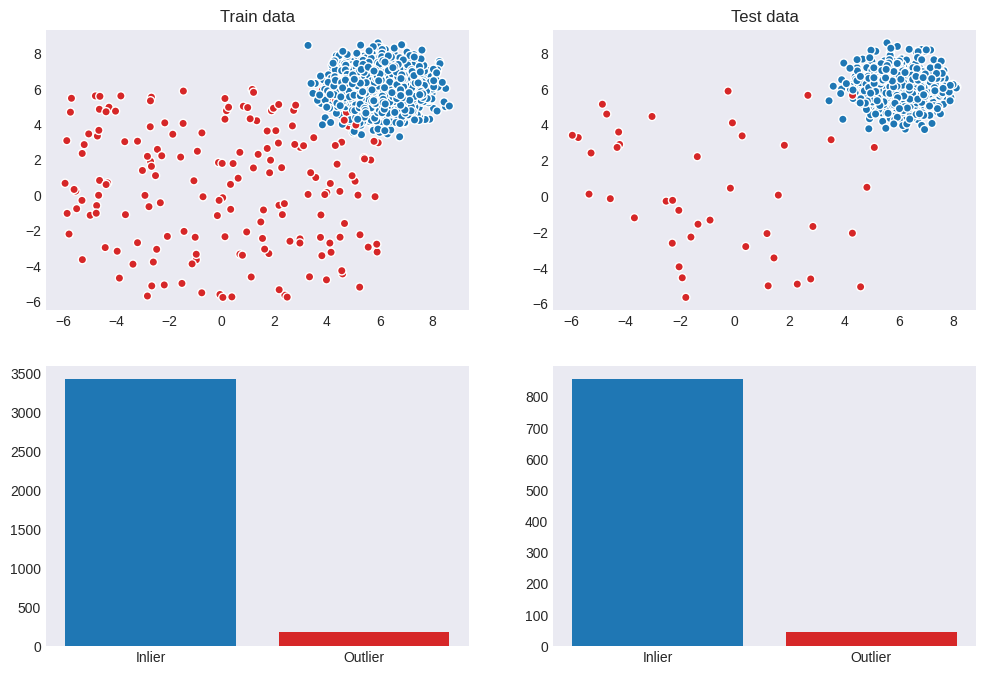

In [19]:
f, ax = plt.subplots(2, 2, figsize=(12,8))

train_plot = (
    pd
    .DataFrame(X_train)
    .assign(target=y_train)
    .rename(columns={0:'x1',1:'x2'})
)

test_plot =  (
    pd
    .DataFrame(X_test)
    .assign(target=y_test)
    .rename(columns={0:'x1',1:'x2'})
)


for idx,dataset in enumerate([train_plot, test_plot]):
    ##scatter
    ax[0,idx].scatter(dataset.x1, dataset.x2, c=['tab:blue' if x==0 else 'tab:red' for x in dataset.target], edgecolors='white')
    
    ##barplot
    count_data = dataset.target.value_counts()
    ax[1,idx].bar([0,1], count_data, color=['tab:blue','tab:red'])
    ax[1,idx].set_xticks([0,1])
    ax[1,idx].set_xticklabels(['Inlier','Outlier'])


ax[0,0].set_title('Train data')
ax[0,1].set_title('Test data')

plt.show()

## The process

Model Development --> Threshold Determination --> Profile the Normal and Outlier Groups

In [9]:
iso = IsolationForest(random_state=42)
iso.fit(X_train)

IsolationForest(random_state=42)

### Isolation Forest
![](https://editor.analyticsvidhya.com/uploads/24169EIF.gif)

In [11]:
scores = iso.decision_function(X_test)

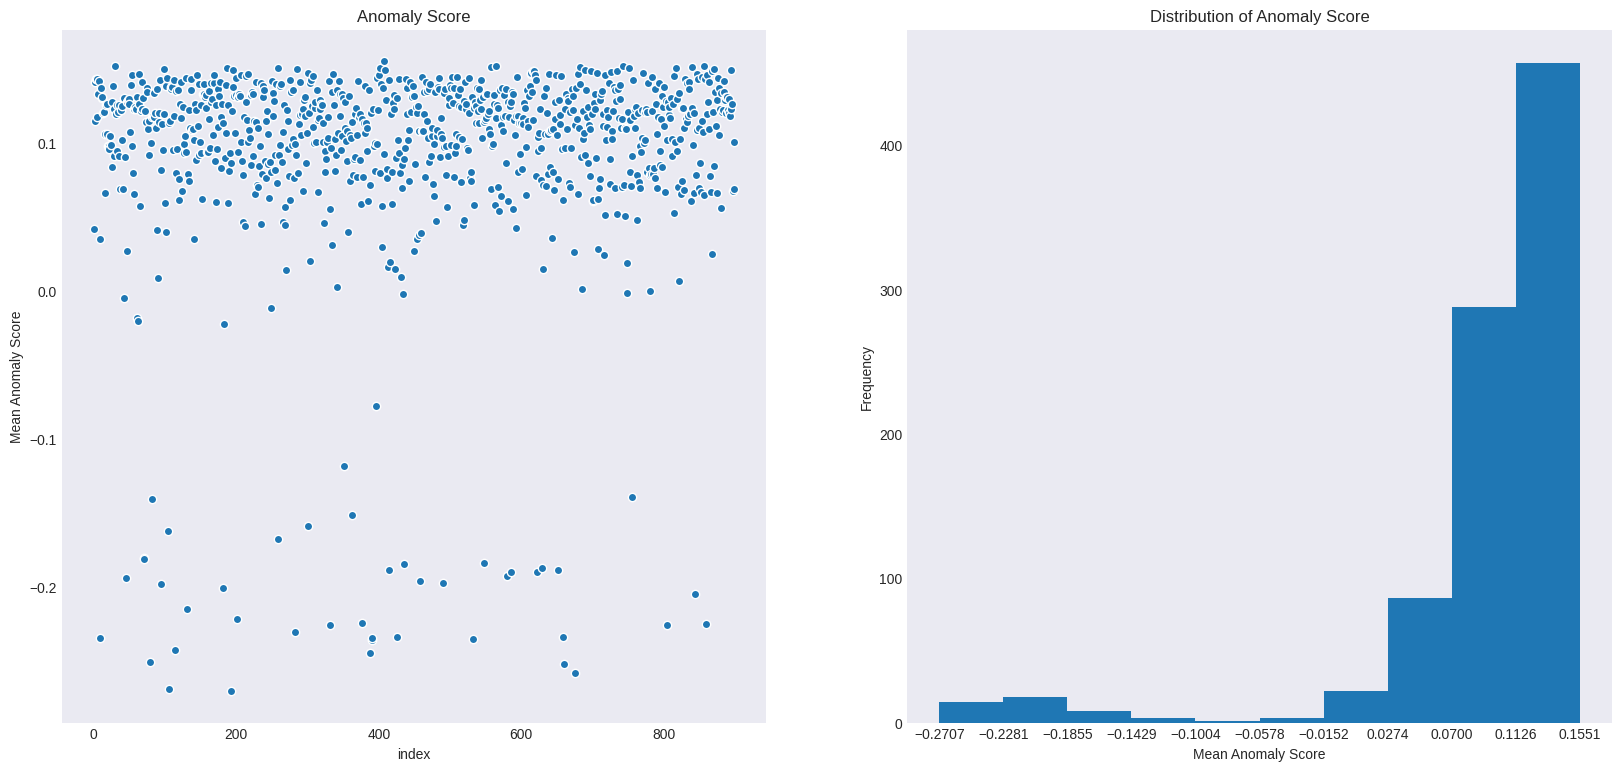

In [13]:
f, ax = plt.subplots(1,2, figsize=(20,9))

data_plot = (
    pd.DataFrame(scores)
    .assign(target=y_test.values)
    .rename(columns={0:'rec_score'})
)

ax[0].scatter(range(len(data_plot.rec_score)),data_plot.rec_score, edgecolors='white')
ax[0].set_title('Anomaly Score')
ax[0].set_ylabel('Mean Anomaly Score')
ax[0].set_xlabel('index')

_, bins, _ = ax[1].hist(scores, align='mid')
ax[1].set_xticks(bins)

ax[1].set_title('Distribution of Anomaly Score')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Mean Anomaly Score')

plt.show()

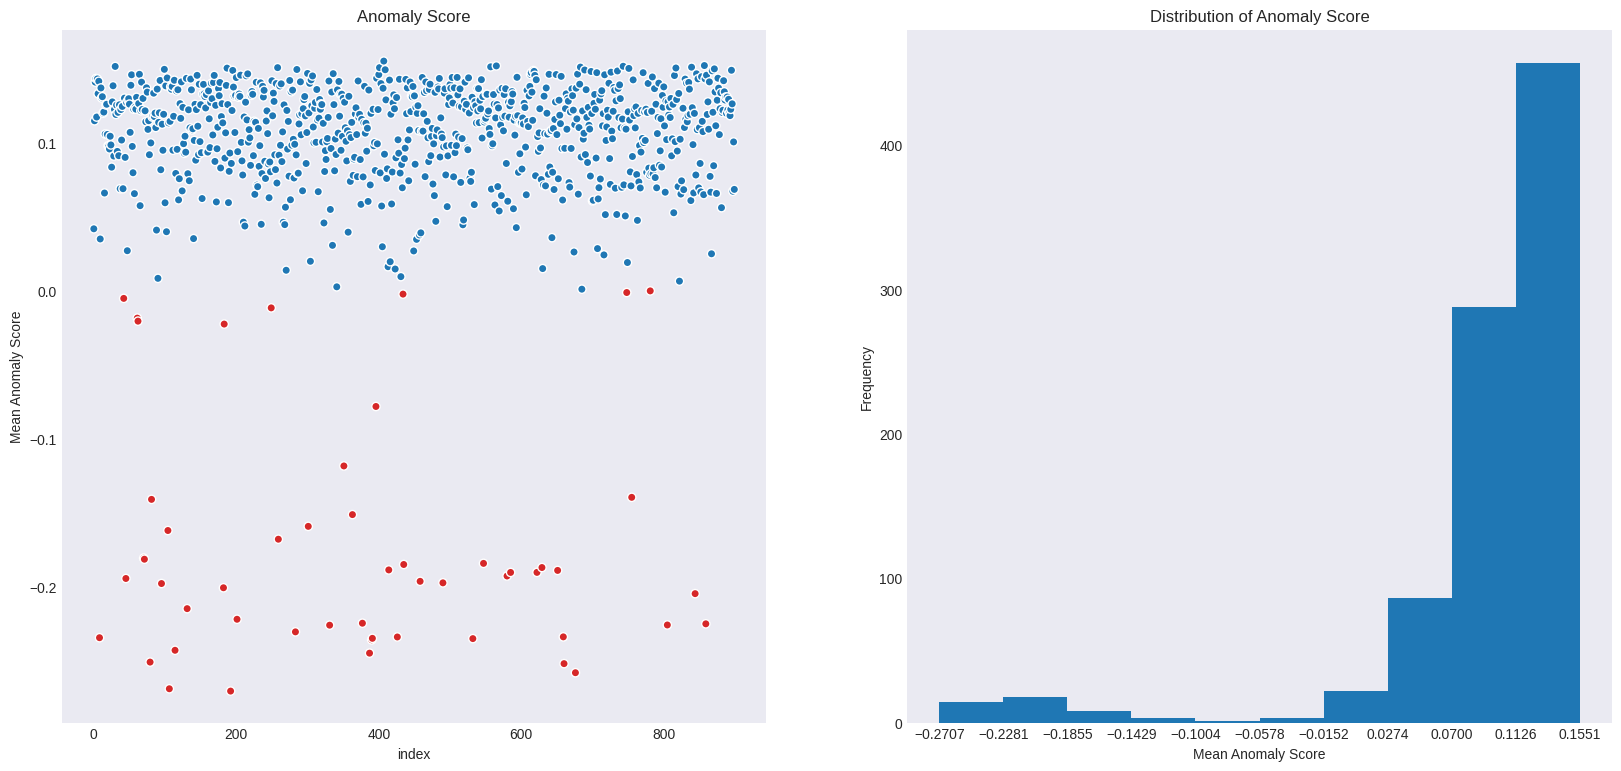

In [38]:
f, ax = plt.subplots(1,2, figsize=(20,9))

data_plot = (
    pd.DataFrame(scores)
    .assign(target=y_test.values)
    .rename(columns={0:'mean_anomaly_score'})
    .assign(iso_predict=[0 if x==1 else 1 for x in iso.predict(X_test)])   
)

ax[0].scatter(
    range(len(data_plot.mean_anomaly_score)),
    data_plot.mean_anomaly_score, 
    edgecolors='white', 
    c=['tab:blue' if x==0 else 'tab:red' for x in data_plot.iso_predict]
)

ax[0].set_title('Anomaly Score')
ax[0].set_ylabel('Mean Anomaly Score')
ax[0].set_xlabel('index')

_, bins, _ = ax[1].hist(scores, align='mid')

ax[1].set_xticks(bins)
ax[1].set_title('Distribution of Anomaly Score')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Mean Anomaly Score')

plt.show()

In [40]:
print(classification_report(data_plot.target,data_plot.iso_predict))

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       855
         1.0       0.87      1.00      0.93        45

    accuracy                           0.99       900
   macro avg       0.93      1.00      0.96       900
weighted avg       0.99      0.99      0.99       900

